In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm

plt.style.use('seaborn-poster')

In [2]:
path_to_data = '/home/Mount_sda1/alexmakh/data_to_paper/'
titlesize = 25

# Compare TS and mirdb

In [3]:
intersec = pd.read_csv(path_to_data + 'comparasion.tsv', sep='\t')
intersec

,isomiRNA,TargetScan full,TargetScan to mirdb size
0,hsa-miR-6750-5p|+1,94.791667,47.916667
1,hsa-miR-3690|-3,94.871795,47.435897
2,hsa-miR-3668|0,93.750000,50.892857
3,hsa-miR-5003-3p|-2,96.052632,55.921053
4,hsa-miR-643|+2,88.607595,55.696203
...,...,...,...
12035,hsa-miR-501-3p|-3,95.555556,52.222222
12036,hsa-miR-7112-3p|-2,95.192308,55.769231
12037,hsa-miR-664a-5p|+2,86.486486,54.054054
12038,hsa-miR-491-3p|0,92.968750,64.062500


In [4]:
def plot_hist_kde(x, title):
#     fig, ax = plt.subplots()
    sns.histplot(data=intersec, x=x, kde=True)
    plt.axvline(intersec[x].mean(), color='r')
    plt.suptitle(title, fontsize=titlesize)
    
    plt.tight_layout()
    plt.show()

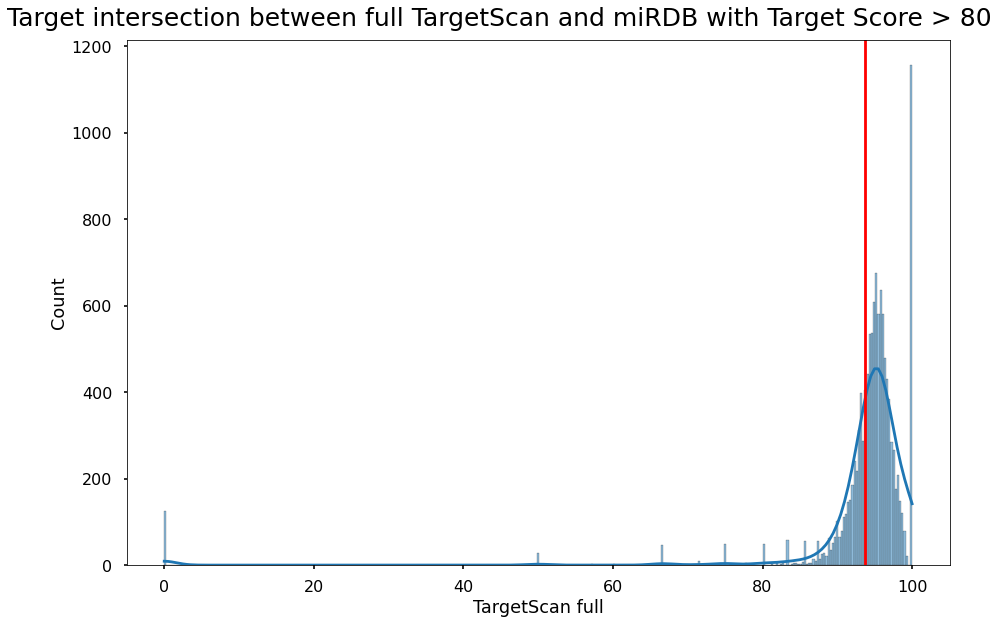

In [5]:
plot_hist_kde('TargetScan full', 'Target intersection between full TargetScan and miRDB with Target Score > 80')

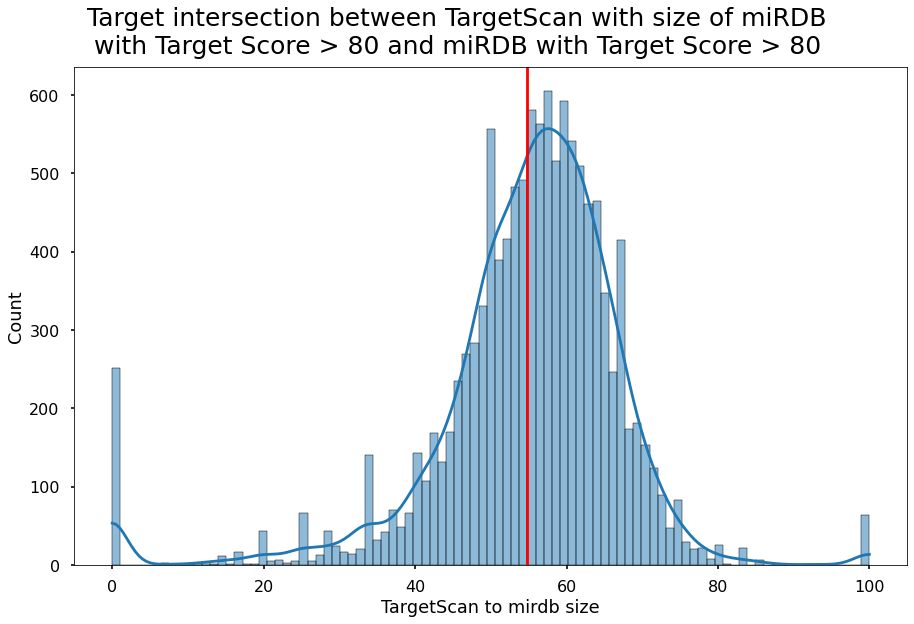

In [6]:
plot_hist_kde('TargetScan to mirdb size', 'Target intersection between TargetScan with size of miRDB\nwith Target Score > 80 and miRDB with Target Score > 80')

# Compare isomiRNAs with one nucleotide difference

In [7]:
def get_num(num):
    num = int(num)
    lower = num - 1
    upper = num + 1
    
    lower = '+' + str(lower) if lower > 0 else str(lower)
    upper = '+' + str(upper) if upper > 0 else str(upper)
    return lower, upper

In [8]:
def get_1_iso_comparasion(df):
    col_upper, col_lower = 'isomiRNA|+1', 'isomiRNA|-1'
    res = pd.DataFrame({}, columns=[col_upper, col_lower])

    mirs = sorted(list(set(df.index)))
    dictir = {}
    for i in tqdm(df.groupby('isomiRNA')):
        dictir[i[0]] = set(i[1]['Gene Symbol'])
    errs1 = set()
    for mir in tqdm(mirs):
        m, i = mir.split('|')
        lower, upper = [m + '|' + j for j in get_num(i)]
        try:
            res.loc[mir, col_lower] = len(dictir[mir] & dictir[lower]) / len(dictir[mir])# | dictir[lower])
        except KeyError:
            errs1.add(lower)
        try:
            res.loc[mir, col_upper] = len(dictir[mir] & dictir[upper]) / len(dictir[mir])# | dictir[upper])
        except KeyError:
            errs1.add(upper)
    return res.copy()

In [ ]:
mirdb = pd.read_csv(path_to_data + 'mirdb_res_full.tsv', sep='\t', index_col=0).iloc[:, :-1]
mirdb1 = get_1_iso_comparasion(mirdb)
mirdb1

In [ ]:
ts = pd.read_csv(path_to_data + 'ts_res_like_mirdb.tsv', sep='\t', index_col=0).iloc[:, :-1]
ts1 = get_1_iso_comparasion(ts)
ts1

In [ ]:
def print_hist_kde1(df, set_, ax):
    x = 'isomiRNA|' + set_
    df = df.dropna(subset=[x], axis=0).astype(float)
    
    sns.histplot(data=df, x=x, kde=True, ax=ax)
    ax.axvline(df[x].mean(), color='r')
    ax.set_title(f'Intersection between isomiRNA and {x}')

def print_1_isomir(df, name):
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    print_hist_kde1(df, '+1', ax[0])
    print_hist_kde1(df, '-1', ax[1])
    fig.suptitle(name, fontsize=titlesize)
    plt.tight_layout()
    plt.show()

In [ ]:
print_1_isomir(mirdb1, 'miRDB')

In [ ]:
print_1_isomir(ts1, 'TargetScan')

# Intersections between projects

In [ ]:
mirdb_path = '/home/alexgorbonos/huge/alexgorbonos/isomiR_research/miRDB/predicted_targets/'
ts_path = '/home/alexgorbonos/huge/alexgorbonos/isomiR_research/TargetScan/predicted_targets/'

files_mirdb = sorted((set(os.listdir(mirdb_path))))
files_ts = set(os.listdir(ts_path))
if files_ts != set(files_mirdb):
    print('Different count of files')

df = pd.DataFrame({}, columns=files_mirdb)
col = 'Gene Symbol'
for file in tqdm(files_mirdb):
    mirdb = pd.read_csv(mirdb_path + file, sep='\t', index_col=0)
    ts = pd.read_csv(ts_path + file, sep='\t', index_col=0)

    mirnas = set(mirdb.index)
    ts_mir = set(ts.index)
    if ts_mir != mirnas:
        print(file_ts, file_mirdb, ts_mir - mirnas, mirnas - ts)

    for mir in mirnas:
        tmp_ts, tmp_mirdb = ts.loc[mir], mirdb.loc[mir]

        if tmp_ts.shape[0] <= 1:
            target_ts = [tmp_ts[col]]
        else:
            target_ts = tmp_ts[col]

        if tmp_mirdb.shape[0] <= 1:
            target_mirdb = [tmp_mirdb[col]]
        else:
            target_mirdb = tmp_mirdb[col]

        tmp_inter = len(set(target_ts) & set(target_mirdb))
        if tmp_ts.shape[0] != tmp_mirdb.shape[0]:
            print('bad file', mir)
            break
        df.loc[mir, file] = tmp_inter / tmp_mirdb.shape[0]
df['median'] = df.median(axis=1)
df['mean'] = df.mean(axis=1)

In [ ]:
tmp = df.iloc[:, :-2].melt().dropna().fillna(-1)
cols = ['Project', 'intersection']
tmp.columns = cols

fig, ax = plt.subplots(1, 1, figsize=(30, 22))
sns.kdeplot(data=tmp, x=cols[1], hue=cols[0])
fig.suptitle('Target intersection between TargetScan and miRDB in TCGA projects', fontsize=titlesize)
plt.tight_layout()
plt.show()

In [ ]:
sns.histplot(data=df, x='median', kde=True)
sns.histplot(data=df, x='mean', kde=True, color='orange', alpha=0.2)
plt.suptitle('Mean and median intersection for each isomiRNA between all projects', fontsize=titlesize)
plt.legend(['median', 'mean'])
plt.tight_layout()
plt.show()